In [1]:
import os
import torch
from torchvision import transforms
from  torchvision.ops import box_iou
from util.augmentations import Compose
from util.data_aug import *
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import torchvision
from util.actions_tree_dqn_batch import Actor
import torch.nn.functional as F
from models.mnist_scale_model import Agent_ae, Net_ae, Net_ae_proj
from datasets.clutter_mnist_scale_rl import MNIST_CoLoc
from RL_entropy import get_policy_loss
import matplotlib.ticker as ticker

img_size = 84
os.environ['CUDA_VISIBLE_DEVICES']='5'

def convert_image_np(inp, norm=True):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    if norm:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)
    return inp


In [2]:
def init_dataloader(sample_size):
    kwargs = {'num_workers': 8, 'pin_memory': True}

    train_transform = Compose([Resize(84)])
    test_transform = Compose([Resize(84)])
    trainset = MNIST_CoLoc(root='.', train=True, digit=4, sample_size=sample_size,
                           datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                           clutter=1, transform=train_transform,
                           )
    testset = MNIST_CoLoc(root='.', train=False, digit=4,
                          datapath='/research/cbim/vast/tl601/Dataset/Synthesis_mnist',
                          clutter=1, transform=test_transform,
                          )

    train_loader = torch.utils.data.DataLoader(
        trainset, batch_size=512, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        testset, batch_size=512, shuffle=False, **kwargs)
    print('total train image: ', len(train_loader.dataset), ' test image: ',
          len(test_loader.dataset))
    return train_loader, test_loader

In [3]:
def init_model(hidden_size, pretrained, freeze=1):
    embeddingnet = Net_ae_proj(pooling_size=7,
              pooling_mode='align').to(device)
    agent = Agent_ae(rnn=1, num_class=10, poolsize=7, 
                  hidden_size=hidden_size).to(device)
    # if load pretrained encoder
    ckpt = torch.load(os.path.join('/research/cbim/vast/tl601/results/'
                                       'mnist/', pretrained))
    if 'state_dict' in ckpt.keys():
        mnist_pretrained_dict = ckpt['state_dict']
    else:
        mnist_pretrained_dict = ckpt
    embeddingnet_dict = embeddingnet.state_dict()

    filtered_dict = {}
    for k, v in mnist_pretrained_dict.items():
        if k in embeddingnet_dict:
            filtered_dict[k] = v
    embeddingnet_dict.update(filtered_dict)
    embeddingnet.load_state_dict(embeddingnet_dict)
    if 'state_dict' in ckpt.keys():
        print('loaded from {}\nckpt epoch {} acc {:.2f}%'.format(pretrained,
                                ckpt['epoch'], ckpt['acc']))
    else:
        print('loaded pretained MNIST encoder ', pretrained)
    if freeze == 1:
        for name, value in embeddingnet.named_parameters():
            value.requires_grad = False

    return embeddingnet, agent


In [4]:
hidden_size = 48
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_loader, test_loader = init_dataloader(sample_size=50)

pretrained = 'pretrain_ae_ord_project_50_lr1e03_step50_2/last.pth.tar'
model, agent = init_model(hidden_size, pretrained)
# load model 
savename = 'ordinal_ae_proj_iou_pg_ent05_50_2_r3'
saveroot = '/research/cbim/vast/tl601/results/selfpaced/ordinal/'
model_path = os.path.join(saveroot, savename, 'best.pth.tar')
print('loading ckpt from ', model_path)
ckpt = torch.load(model_path)
state_dict = ckpt['state_dict']
epoch = ckpt['epoch']
best_loss = ckpt['acc']
agent.load_state_dict(state_dict)
print(("=> loaded checkpoint epoch {} {}".format(epoch, best_loss)))

total train image:  50  test image:  982
loaded from pretrain_ae_ord_project_50_lr1e03_step50_2/last.pth.tar
ckpt epoch 149 acc 94.81%
loading ckpt from  /research/cbim/vast/tl601/results/selfpaced/ordinal/ordinal_ae_proj_iou_pg_ent05_50_2_r3/best.pth.tar
=> loaded checkpoint epoch 212 92.15885925292969


In [5]:
# draw arrow 
def draw_arrow(x, y, dx, dy):
    '''
    direction is up/down/left/right
    '''
    plt.arrow(x, y, dx, dy, length_includes_head=True, fc='y',
      head_width=0.08, head_length=0.00002)

ious  tensor([[0.1111, 0.1746, 0.2791, 0.4240, 0.6588, 0.6588, 0.6588, 0.6588, 0.6588,
         0.8116, 0.8116],
        [0.1111, 0.1696, 0.2592, 0.3872, 0.5727, 0.5727, 0.5727, 0.5727, 0.5727,
         0.6286, 0.6286],
        [0.1111, 0.0681, 0.0882, 0.1746, 0.2333, 0.2689, 0.4144, 0.5688, 0.7383,
         0.7615, 0.7615],
        [0.1111, 0.1721, 0.2739, 0.2739, 0.4242, 0.6405, 0.8721, 0.8721, 0.8721,
         0.8721, 0.8721],
        [0.1111, 0.1746, 0.2301, 0.2791, 0.2301, 0.2466, 0.4000, 0.5496, 0.6912,
         0.6912, 0.6912]])
rewards  tensor([[ 1.,  1.,  1.,  1.,  3.,  3.,  3.,  3.,  1.,  3.],
        [ 1.,  1.,  1.,  1.,  3.,  3.,  3.,  3.,  1.,  3.],
        [-1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  3.],
        [ 1.,  1., -1.,  1.,  1.,  1.,  3.,  3.,  3.,  3.],
        [ 1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  3.,  3.]], device='cuda:0')


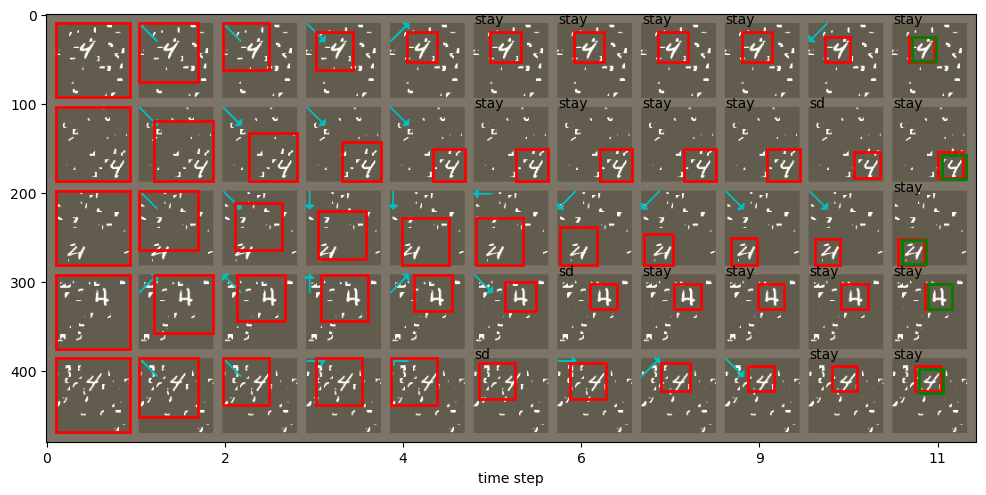

In [14]:
# visualize actions
seq_len = 10
num = 5
with torch.no_grad():
    model.eval()
    agent.eval()
    data_org, target_org = next(iter(train_loader))
    batch_size = data_org.shape[0]
    data_org, target_org = data_org.to(device), target_org.float()
    data, target = data_org[:num], target_org[:num]
    img = convert_image_np(torchvision.utils.make_grid(data.repeat(1, seq_len+1, 1, 1).view(num*(seq_len+1),
                                1, data.shape[2], data.shape[3]).cpu(), nrow=seq_len+1,
                                    padding=10), norm=True)

    fig = plt.figure(figsize=(12, 8), dpi= 100)
    ax = fig.add_subplot(1, 1, 1)
    ax.imshow(img)

    state = data_org.clone()
    all_embed = []
    logits_seq = []
    pred_boxes = torch.tensor([[0,0,83,83]]).float().repeat(batch_size, 1)
    boxes = [pred_boxes]
    rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
    org_boxes = pred_boxes.clone().to(device)
    rois_t0 = torch.cat((torch.arange(0, batch_size).float().view(-1, 1),
                            target_org), dim=1).to(device)
    action_seq = torch.IntTensor(batch_size, seq_len).to(device)
    rewards_all = torch.zeros((batch_size, seq_len)).to(device)
    actor = Actor(data_org, targets=target_org, min_box_side=28)
    if hidden_size:
        h_t = torch.zeros(
            batch_size,
            hidden_size,
            dtype=torch.float,
            device=device,
            requires_grad=True,
        )
    # 1st forward classifier
    with torch.no_grad():
        embed, _ = model(data_org, rois)
        
    ious = [actor.ious[:num].clone()]
    for t in range(seq_len):
        if hidden_size:
            h_t, logits, actions = agent(embed, h_t_prev=h_t)
        else:
            logits, actions = agent(embed)
        reward, pred_boxes = actor.takeaction(actions)
        rois = torch.cat((torch.arange(0, batch_size).float().view(-1, 1).to(device),
                          pred_boxes.to(device)), dim=1)
        with torch.no_grad():
            embed, _ = model.get_roi_embedding(rois)
        rewards_all[:, t] = reward
        action_seq[:, t] = actions.view(1, -1)
        logits_seq.append(logits)
        boxes.append(pred_boxes)
        ious.append(actor.ious[:num].clone())
    
    print('ious ', torch.stack(ious).permute(1,0 ))
    print('rewards ', rewards_all[:num])
    for t in range(len(boxes)):
        for i, b in enumerate(boxes[t][:num]): # (num ,4)
            change_y = i * (img_size+10) + 10
            change_x = t * (img_size+10) + 10
            b[1::2] += change_y # change y1, y2
            b[::2] += change_x     # 
            #print('t ', t, ' change_y ', change_y, ' change_x ', change_x)
            
            if t>0:
                if action_seq[i, t-1] == 0: #shrink towards TL
                    plt.arrow(change_x+20, change_y+20, -20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 1: #shrink towards TR
                    plt.arrow(change_x, change_y+20, 20, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 2: #shrink toward bottom left
                    plt.arrow(change_x+20, change_y, -20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 3: #shrink toward bottom right 
                    plt.arrow(change_x, change_y, 20, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 4: # scale down
                    plt.text(change_x, change_y, 'sd')
                elif action_seq[i,t-1] == 5: #stay 
                    plt.text(change_x, change_y, 'stay')
                elif action_seq[i,t-1] == 6: #left 
                    plt.arrow(change_x+20, change_y+3, -20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 7: # right
                    plt.arrow(change_x, change_y+3, 20, 0, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 8: # up
                    plt.arrow(change_x+3, change_y+20, 0, -20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 9: # down
                    plt.arrow(change_x+3, change_y, 0, 20, length_includes_head=True, color='c',
                      head_width=10, head_length=4)
                elif action_seq[i,t-1] == 10: # higher
                    plt.text(change_x, change_y, 'higher')
                elif action_seq[i,t-1] == 11: # wider
                    plt.text(change_x, change_y, 'wider')
                elif action_seq[i,t-1] == 12: # narrower
                    plt.text(change_x, change_y, 'narrower')
                elif action_seq[i,t-1] == 13: # shorter
                    plt.text(change_x, change_y, 'shorter')
            
    
    for i in range(target.shape[0]):
        target[i, 1::2] += i * (img_size+10) + 10
        target[i, ::2]  += seq_len * (img_size+10) + 10
    
    for box in boxes:
        for x1, y1, x2, y2 in box[:num]:
            patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='r', facecolor='none', fill=False)
            ax.add_patch(patch)
            
    for x1, y1, x2, y2 in target:
        patch = Rectangle((x1, y1), x2-x1, y2-y1, linewidth=2,
                              edgecolor='g', facecolor='none', fill=False)
        ax.add_patch(patch)
    
    ax.set_xlabel('time step')
    scale_x = img_size + 10
    ticks_x = ticker.FuncFormatter(lambda x, pos: '{:.0f}'.format(x / scale_x))
    ax.xaxis.set_major_formatter(ticks_x)
    plt.show()

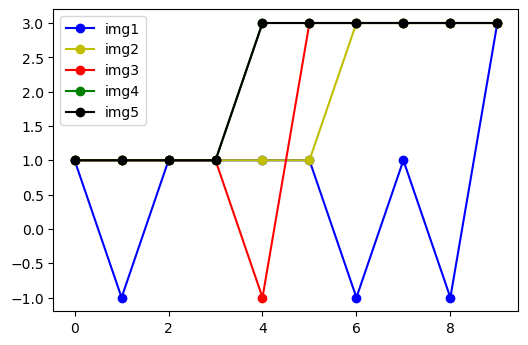

In [7]:
# plot rewards_all, i.e., distance to target
colors = ['b', 'y','r','g','k']
fig = plt.figure(dpi= 100)
ax = fig.add_subplot(1, 1, 1)
for i, r in enumerate(rewards_all[:5].cpu().numpy()):
    plt.plot(range(seq_len), r, colors[i], label="img{}".format(i+1), marker='o')
plt.legend()
plt.show()